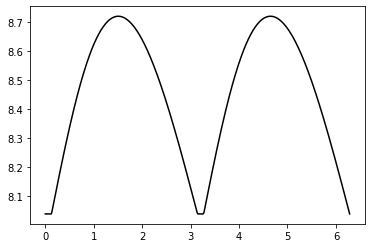

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

def tdur_I(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s, P=1440, a=628):
    return (tdur - P/(2*np.pi*a) * (2*R_S+2*R_p+a_p*np.sin(phi)-a_p*np.sin(phi+2*np.pi*tdur/Pbin)))**2

def tdur_II(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s, P=1440, a=628):
    return (tdur - P/(2*np.pi*a) * (2*R_S+R_p+R_s+a_p*np.sin(phi)+a_s*np.sin(phi+2*np.pi*tdur/Pbin)))**2

def tdur_III(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s, P=1440, a=628):
    return (tdur - P/(2*np.pi*a) * (2*R_S+R_p+R_s-a_s*np.sin(phi)-a_p*np.sin(phi+2*np.pi*tdur/Pbin)))**2

def tdur_IV(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s, P=1440, a=628):
    return (tdur - P/(2*np.pi*a) * (2*R_S+2*R_s-a_s*np.sin(phi)+a_s*np.sin(phi+2*np.pi*tdur/Pbin)))**2

def tdur(phi, R_S=9.9512, R_p=1, R_s=1, a_sp=2, P=1500, a=615):
    a_p = R_s**3/(R_s**3+R_p**3) * a_sp
    a_s = R_p**3/(R_s**3+R_p**3) * a_sp
    Pbin = 2*np.pi/3600 / np.sqrt(6.6743*10**-11*(R_p**3+R_s**3)*1.899*10**27/(a_sp*(R_s+R_p)*(7.149*10**7))**3)
    caseI = minimize(lambda tdur: tdur_I(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s), x0=9)['x'][0]
    caseII = minimize(lambda tdur: tdur_II(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s), x0=9)['x'][0]
    caseIII = minimize(lambda tdur: tdur_III(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s), x0=9)['x'][0]
    caseIV = minimize(lambda tdur: tdur_IV(tdur, phi, Pbin, R_S, R_p, R_s, a_p, a_s), x0=9)['x'][0]
    return max(caseI, caseII, caseIII, caseIV)
    
phis = np.linspace(0, 2*np.pi, 400)
tdurs = np.array([tdur(phi, R_p=1, R_s=1, a_sp=2) for phi in phis])
plt.plot(phis, tdurs, color='black')

In [2]:
from scipy import integrate
integrate.quad(lambda phi: tdur(phi)**2, 0, 2*np.pi)

<ipython-input-2-5d9afac055c7>:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(lambda phi: tdur(phi)**2, 0, 2*np.pi)


(449.81789854543536, 3.184020486275248e-05)

In [3]:
def numderiv(f, a, h=0.01):
    return (f(a + h) - f(a - h))/(2*h)

def dtdp(phi, R_p=1, R_s=1, a_sp=2, P=1500, a=615):
    a_p = R_s**3/(R_s**3+R_p**3) * a_sp
    a_s = R_p**3/(R_s**3+R_p**3) * a_sp
    td = tdur(phi, R_p=R_p, R_s=R_s, a_sp=a_sp)
    Pbin = 2*np.pi/3600 / np.sqrt(6.6743*10**-11*(R_p**3+R_s**3)*1.899*10**27/(a_sp*(R_s+R_p)*(7.149*10**7))**3)
    
    if np.sin(phi) > (-R_p+R_s)/(a_p+a_s):
        if np.sin(phi + 2*np.pi*td/Pbin) < (R_p-R_s)/(a_p+a_s): #case I
            return P*Pbin/(2*np.pi) * (a_p*np.cos(phi)-a_p*np.cos(phi+2*np.pi*td/Pbin)) / (a*Pbin+a_p*P*np.cos(phi+2*np.pi*td/Pbin))
        else: #case II
            return P*Pbin/(2*np.pi) * (a_p*np.cos(phi)+a_s*np.cos(phi+2*np.pi*td/Pbin)) / (a*Pbin-a_s*P*np.cos(phi+2*np.pi*td/Pbin))
    else:
        if np.sin(phi + 2*np.pi*td/Pbin) < (R_p-R_s)/(a_p+a_s): #case III
            return P*Pbin/(2*np.pi) * (-a_s*np.cos(phi)-a_p*np.cos(phi+2*np.pi*td/Pbin)) / (a*Pbin+a_p*P*np.cos(phi+2*np.pi*td/Pbin))
        else: #case IV
            return P*Pbin/(2*np.pi) * (-a_s*np.cos(phi)+a_s*np.cos(phi+2*np.pi*td/Pbin)) / (a*Pbin-a_s*P*np.cos(phi+2*np.pi*td/Pbin))
def approx_zeros(x, fx):
    zeros = []
    for i in range(len(fx)-1):
        if np.sign(fx[i]) != np.sign(fx[i+1]):
            if np.abs(fx[i]) < np.abs(fx[i+1]):
                zeros.append(x[i])
            else:
                zeros.append(x[i])
    return zeros

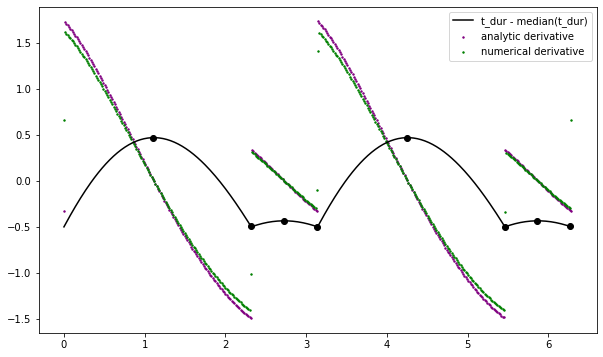

In [4]:
Rs = 1
asp = 5
tdurs = np.array([tdur(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
dtdur_dphi = [numderiv(lambda phi: tdur(phi, R_p=1, R_s=Rs, a_sp=asp), phi) for phi in phis]
deriv_analytic = np.array([dtdp(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
zeros = approx_zeros(phis, dtdur_dphi)
plt.figure(figsize=(10, 6))
plt.scatter(phis, deriv_analytic, color='purple', label='analytic derivative', s=2)
plt.scatter(phis, dtdur_dphi, color='green', label='numerical derivative', s=2)
plt.plot(phis, tdurs - np.median(tdurs), color='black', label='t_dur - median(t_dur)')

plt.scatter(zeros, [tdur(zero, R_p=1, R_s=Rs, a_sp=asp) for zero in zeros] - np.median(tdurs), color='black')
# plt.scatter(0, tdur(0, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')
# plt.scatter(2*np.pi, tdur(2*np.pi, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')

plt.legend()

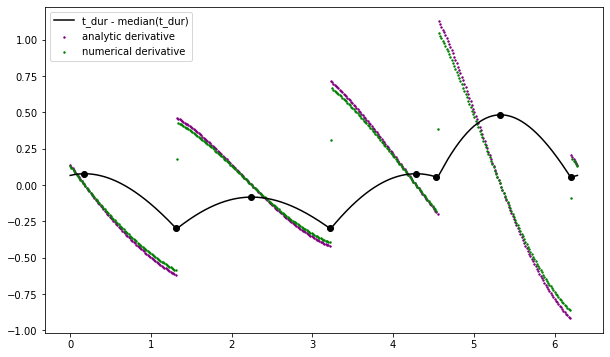

In [77]:
Rs = 0.75
asp = 3
tdurs = np.array([tdur(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
dtdur_dphi = [numderiv(lambda phi: tdur(phi, R_p=1, R_s=Rs, a_sp=asp), phi) for phi in phis]
deriv_analytic = np.array([dtdp(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
zeros = approx_zeros(phis, dtdur_dphi)
plt.figure(figsize=(10, 6))
plt.scatter(phis, deriv_analytic, color='purple', label='analytic derivative', s=2)
plt.scatter(phis, dtdur_dphi, color='green', label='numerical derivative', s=2)
plt.plot(phis, tdurs - np.median(tdurs), color='black', label='t_dur - median(t_dur)')

plt.scatter(zeros, [tdur(zero, R_p=1, R_s=Rs, a_sp=asp) for zero in zeros] - np.median(tdurs), color='black')
# plt.scatter(0, tdur(0, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')
# plt.scatter(2*np.pi, tdur(2*np.pi, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')

plt.legend()

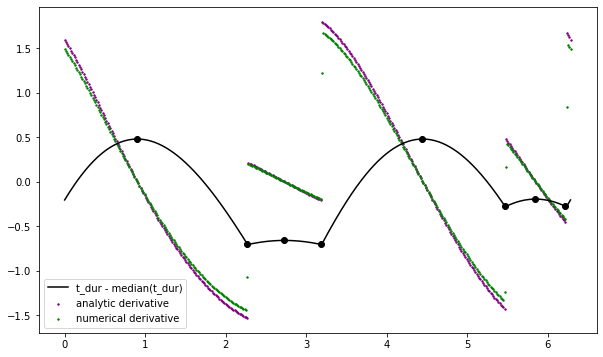

In [6]:
Rs = 0.75
asp = 5
tdurs = np.array([tdur(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
dtdur_dphi = [numderiv(lambda phi: tdur(phi, R_p=1, R_s=Rs, a_sp=asp), phi) for phi in phis]
deriv_analytic = np.array([dtdp(phi, R_p=1, R_s=Rs, a_sp=asp) for phi in phis])
zeros = approx_zeros(phis, dtdur_dphi)
plt.figure(figsize=(10, 6))
plt.scatter(phis, deriv_analytic, color='purple', label='analytic derivative', s=2)
plt.scatter(phis, dtdur_dphi, color='green', label='numerical derivative', s=2)
plt.plot(phis, tdurs - np.median(tdurs), color='black', label='t_dur - median(t_dur)')

plt.scatter(zeros, [tdur(zero, R_p=1, R_s=Rs, a_sp=asp) for zero in zeros] - np.median(tdurs), color='black')
# plt.scatter(0, tdur(0, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')
# plt.scatter(2*np.pi, tdur(2*np.pi, R_p=1, R_s=Rs, a_sp=asp) - np.median(tdurs), color='black')

plt.legend()

0
10
20
30
40
50
60
70
80
90


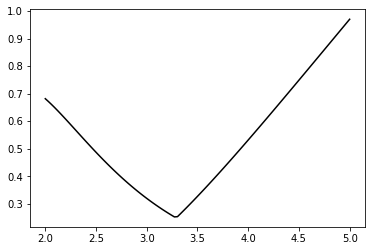

In [17]:
phis = np.linspace(0, 2*np.pi, 400)
p2ps = []
maxs = []
mins = []
a_sps = np.linspace(2., 5., 100)
i=0
for a_sp in a_sps:
    tdurs = np.array([tdur(phi, R_p=1, R_s=1, a_sp=a_sp) for phi in phis])
    durmax = np.max(tdurs)
    durmin = np.min(tdurs)
    maxs.append(durmax)
    mins.append(durmin)
    p2ps.append(durmax-durmin)
    if i%10==0:
        print(i)
    i += 1
plt.plot(a_sps, p2ps, color='black')

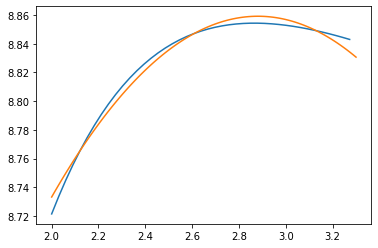

In [42]:
caseI = np.where(a_sps<3.3)
plt.plot(np.array(a_sps)[caseI], np.array(maxs)[caseI])
fit = np.polyfit(np.array(a_sps)[caseI], np.array(maxs)[caseI], 2)
x = np.linspace(2, 3.3, 100)
bestfit = np.zeros_like(x)
for par in range(len(fit)):
    bestfit += x**(len(fit)-1-par)*fit[par]
plt.plot(x, bestfit)
# plt.plot(np.array(a_sps)[caseI], np.array(mins)[caseI])

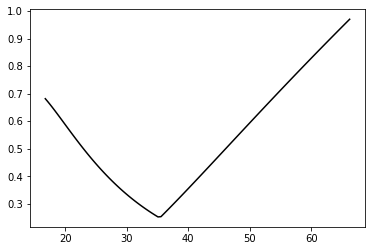

In [13]:
def Pbin(a_sp, R_p=1, R_s=1):
    a_p = R_s**3/(R_s**3+R_p**3) * a_sp
    a_s = R_p**3/(R_s**3+R_p**3) * a_sp
    Pbin = 2*np.pi/3600 / np.sqrt(6.6743*10**-11*(R_p**3+R_s**3)*1.899*10**27/(a_sp*(R_s+R_p)*(7.149*10**7))**3)
    return Pbin
P_bins = [Pbin(a_sp) for a_sp in a_sps]
plt.plot(P_bins, p2ps, color='black')

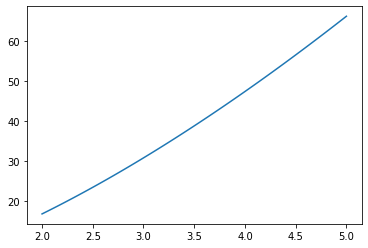

In [14]:
plt.plot(a_sps, P_bins)